<a href="https://colab.research.google.com/github/shadiAndishe/Solar_power_prediction/blob/main/Solar_power_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [ ]:
# power generation datasets
g1 = pd.read_csv("/content/drive/MyDrive/Solar_power_generation/Plant_1_Generation_Data.csv")
g1.head()
g2 = pd.read_csv("/content/drive/MyDrive/Solar_power_generation/Plant_2_Generation_Data.csv")
g2.head()

In [ ]:
# sensor datasets
s1 = pd.read_csv("/content/drive/MyDrive/Solar_power_generation/Plant_1_Weather_Sensor_Data.csv')
s1.head()

<ipython-input-18-827bf931bba4>:8: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], dayfirst=True)


Epoch 1, Loss: 0.0196
Epoch 2, Loss: 0.0124
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0008
Epoch 5, Loss: 0.0015
Epoch 6, Loss: 0.0065
Epoch 7, Loss: 0.0002
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0003
Epoch 10, Loss: 0.0074
Epoch 11, Loss: 0.0001
Epoch 12, Loss: 0.0001
Epoch 13, Loss: 0.0022
Epoch 14, Loss: 0.0006
Epoch 15, Loss: 0.0003
Epoch 16, Loss: 0.0009
Epoch 17, Loss: 0.0004
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0002
Epoch 22, Loss: 0.0001
Epoch 23, Loss: 0.0001
Epoch 24, Loss: 0.0000
Epoch 25, Loss: 0.0004
Epoch 26, Loss: 0.0001
Epoch 27, Loss: 0.0002
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0001
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0001
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0001
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0039
Epoch 43, Loss: 0.0000
Epoch 44, Loss: 0.00

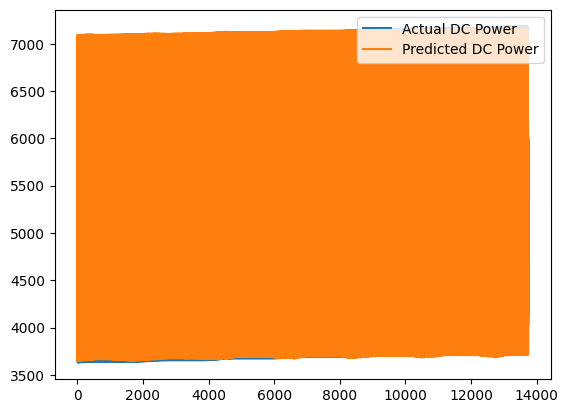

In [ ]:
# Load the data
gen_data = pd.read_csv('/content/drive/MyDrive/Solar_power_generation/Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('/content/drive/MyDrive/Solar_power_generation/Plant_1_Weather_Sensor_Data.csv')


# Convert timestamp to datetime with correct format
gen_data['DATE_TIME'] = pd.to_datetime(gen_data['DATE_TIME'], dayfirst=True)
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'], dayfirst=True)

# Merge datasets on timestamp
merged_data = pd.merge(gen_data, weather_data, on=['DATE_TIME', 'PLANT_ID'], how='inner')

# Select relevant features
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'TOTAL_YIELD']
target = 'DC_POWER'

# Normalize features with MinMaxScaler and target with StandardScaler
feature_scaler = MinMaxScaler()
target_scaler = StandardScaler()

merged_data[features] = feature_scaler.fit_transform(merged_data[features])
merged_data[[target]] = target_scaler.fit_transform(merged_data[[target]])

# Prepare sequences for LSTM
def create_sequences(data, target_col_index, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length, target_col_index])
    return np.array(sequences), np.array(labels)

seq_length = 24
target_index = merged_data.columns.get_loc(target)
X, y = create_sequences(merged_data[features].values, target_index, seq_length)

# Split data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
class SolarDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SolarDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(SolarDataset(X_test, y_test), batch_size=32, shuffle=False)

# Define LSTM model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Initialize model with increased complexity
model = LSTMPredictor(input_size=len(features), hidden_size=128, num_layers=3, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Reduced learning rate

# Train model with more epochs
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Evaluate model
model.eval()
y_preds = []
y_actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_preds.extend(model(X_batch).squeeze().numpy())
        y_actuals.extend(y_batch.numpy())

# Convert back to original scale
y_preds = target_scaler.inverse_transform(np.array(y_preds).reshape(-1, 1))
y_actuals = target_scaler.inverse_transform(np.array(y_actuals).reshape(-1, 1))

# Visualization
import matplotlib.pyplot as plt
plt.plot(y_actuals, label='Actual DC Power')
plt.plot(y_preds, label='Predicted DC Power')
plt.legend()
plt.show()
